# Snapshot from .vtp

In [2]:
import pathlib
import warnings

from cfdmod.use_cases.snapshot.snapshot import take_snapshot
from cfdmod.use_cases.snapshot.config import (
    ValueTagsConfig,
    LegendConfig,
    ImageConfig,
    ProjectionConfig,
    SnapshotConfig,
)
from cfdmod.utils import create_folder_path

In [3]:
# to run on remote Linux environment:
from xvfbwrapper import Xvfb

# Start virtual display
vdisplay = Xvfb(width=2874, height=1634, colordepth=24)
vdisplay.start()

<div style="text-align: center"> edit: </div>

- define the paths

In [7]:
repo_path = pathlib.Path('/home/ubuntu/users/aron/repos/cfdmod')
files_path = repo_path / "fixtures/tests/snapshot"
output_path = pathlib.Path("./output/images")
snapshot_config_path = files_path / "snapshot_params_example.yaml"
create_folder_path(output_path)

- wind_dirs: a list of strings that represents wind directions, used to create the path to each projection in each image
- images: configuration to generate images
  - name: name that represents the image
  - legend_config: configuration of the label in the image
  - projections: a set of key value pair of projections names and partial projection config (only the part thats differs in each projection)

In [8]:
wind_dirs = [angle for angle in range(0, 60, 30)]
images = [
    ImageConfig(
        name=f"{wind_dir:03}",
        legend_config=LegendConfig(label="cp_equivalent_mean", range=[-2.25, 1.5], n_divs=15),
        projections={
            "top_projection": ProjectionConfig(
                file_path=files_path / f"{wind_dir:03}.vtp",
                scalar="min",
                values_tag_config=ValueTagsConfig(spacing=25, padding=(5, 10)),
            ),
            "front_projection": ProjectionConfig(
                file_path=files_path / f"{wind_dir:03}.vtp",
                scalar=f"{'max' if wind_dir > 270 or wind_dir < 90 else 'min'}",
                values_tag_config=ValueTagsConfig(spacing=25, padding=(5, 10)),
            ),
            "back_projection": ProjectionConfig(
                file_path=files_path / f"{wind_dir:03}.vtp",
                scalar=f"{'max' if wind_dir > 90 and wind_dir < 270 else 'min'}",
                values_tag_config=ValueTagsConfig(spacing=25, padding=(5, 10)),
            ),
            "right_projection": ProjectionConfig(
                file_path=files_path / f"{wind_dir:03}.vtp",
                scalar=f"{'max' if wind_dir > 180 and wind_dir < 360 else 'min'}",
                values_tag_config=ValueTagsConfig(spacing=25, padding=(5, 10)),
            ),
            "left_projection": ProjectionConfig(
                file_path=files_path / f"{wind_dir:03}.vtp",
                scalar=f"{'max' if wind_dir > 0 and wind_dir < 180 else 'min'}",
                values_tag_config=ValueTagsConfig(spacing=25, padding=(5, 10)),
            ),
        },
    )
    for wind_dir in wind_dirs
]

<div style="text-align: center"> execute: </div>

- a base snapshot configuration is created using an YAML file. Each image configuration subscribes some parts, creating the final configuration for the image.
- For each image configuration, the snapshot base configuration will be modified according to the settings for the respective image.

image_path=PosixPath('../../../../fixtures/tests/snapshot/axis_icon.png') position=(1000.0, 500.0) angle=-90.0 scale=1.5 transparency=0.0
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=63x72 at 0x6FFF7C030650>


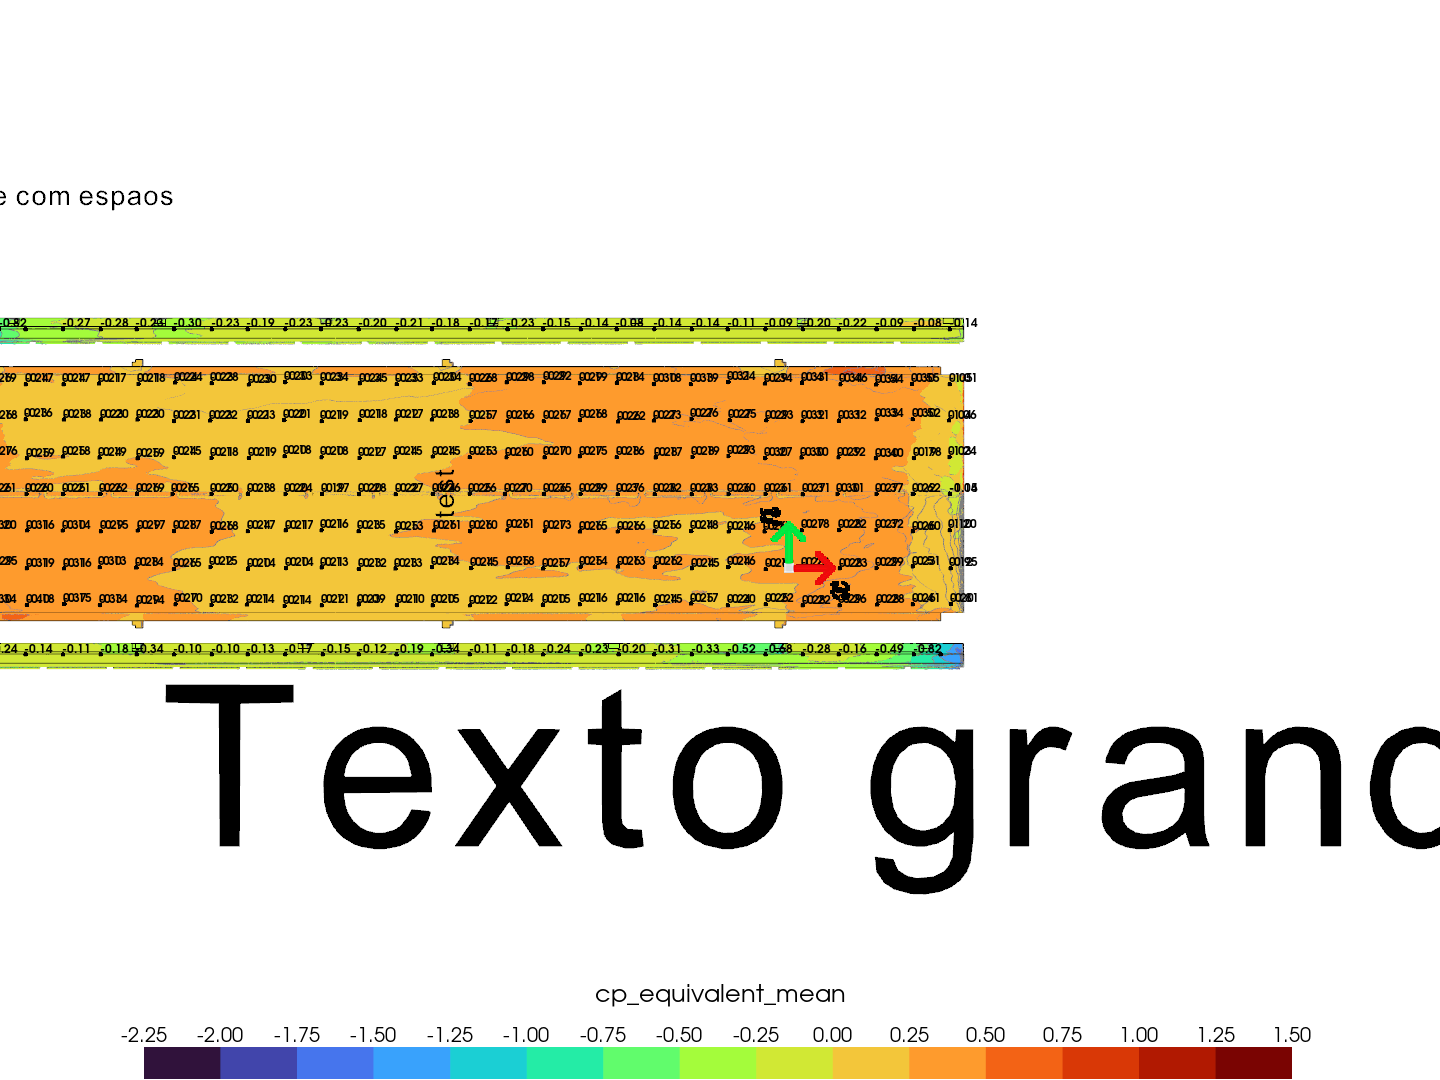

image_path=PosixPath('../../../../fixtures/tests/snapshot/axis_icon.png') position=(1000.0, 500.0) angle=-90.0 scale=1.5 transparency=0.0
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=63x72 at 0x6FFF717207D0>


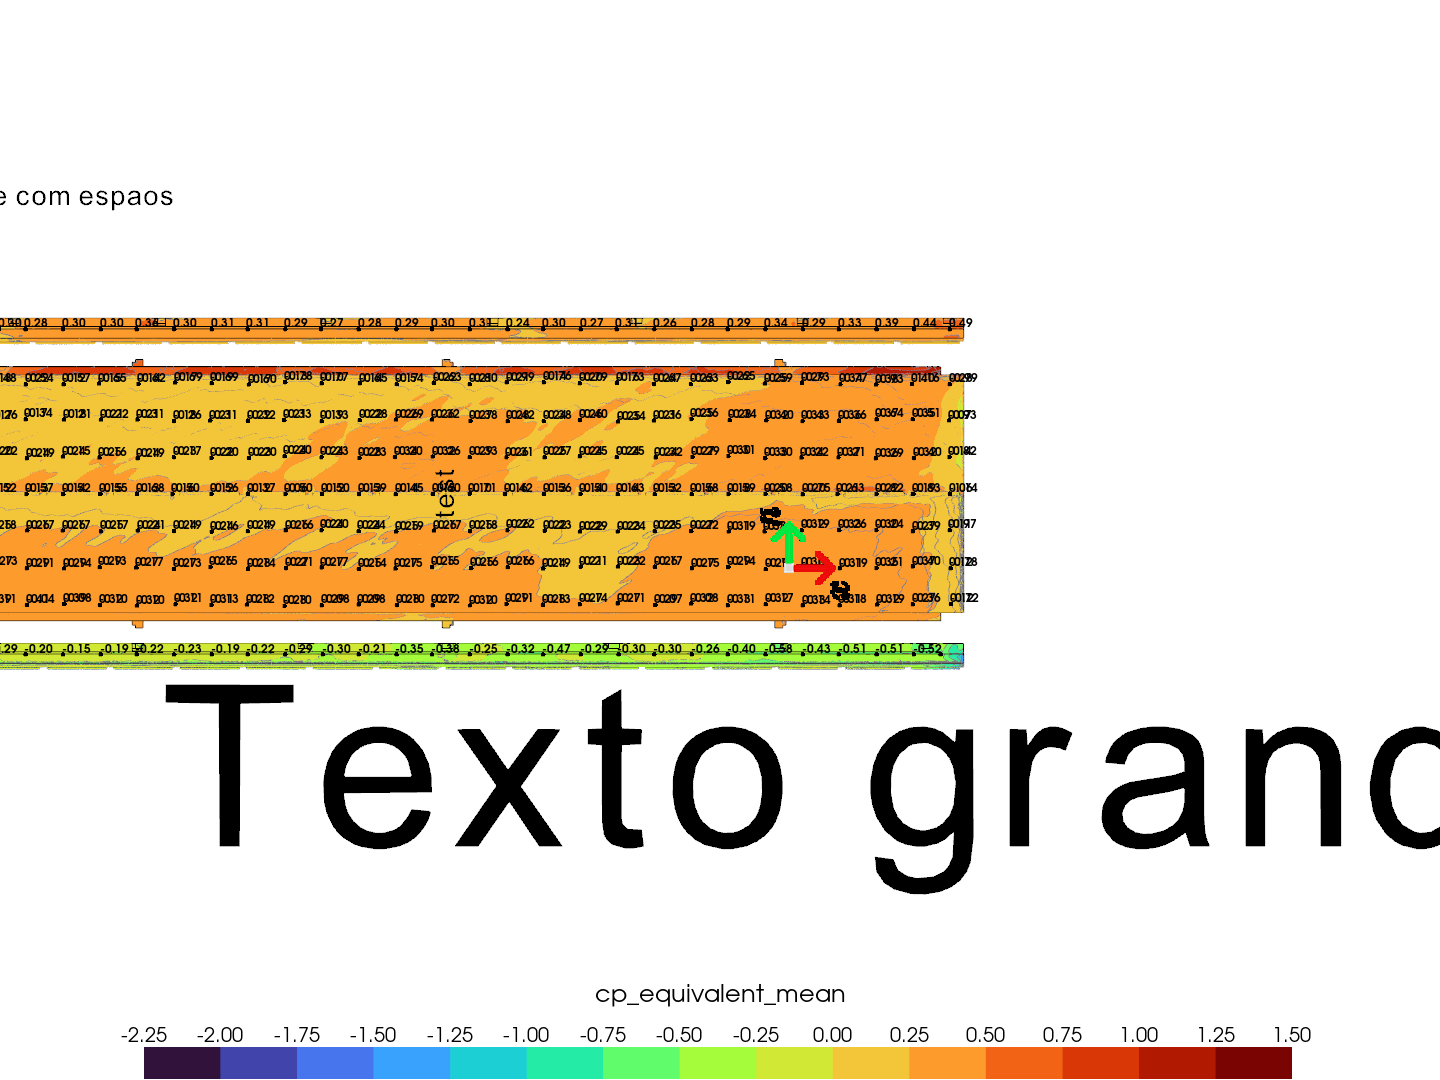

In [11]:
snapshot_config = SnapshotConfig.from_file(snapshot_config_path)

for image in images:
    for projection_key in image.projections:
        snapshot_config.projections[projection_key].file_path = image.projections[
            projection_key
        ].file_path
        snapshot_config.projections[projection_key].scalar = image.projections[
            projection_key
        ].scalar
        snapshot_config.projections[projection_key].values_tag_config = image.projections[
            projection_key
        ].values_tag_config
        snapshot_config.legend_config = image.legend_config

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        take_snapshot(
            output_path / f"{image.name}.png",
            snapshot_config
        )